## Imports

In [2]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

import seaborn as sns

# from itertools import cycle, islice
# colors = np.array(
#             list(
#                 islice(
#                     cycle(
#                         [
#                             "#377eb8",
#                             "#ff7f00",
#                             "#4daf4a",
#                             "#f781bf",
#                             "#a65628",
#                             "#984ea3",
#                             "#999999",
#                             "#e41a1c",
#                             "#dede00",
#                         ]
#                     ),
#                     int(max(y) + 1),
#                 )
#             )
#         )
#         # add black color for outliers (if any)
# colors = np.append(colors, ["#000000"])

SEED = 42

In [3]:
torch.cuda.is_available()

True

## Model architecrure

In [3]:
class BilinearUnit(nn.Module):
    def __init__(self, in1_dim, in2_dim, out_dim):
        super().__init__()
        self.unit = torch.nn.Bilinear(in1_dim, in2_dim, out_dim, bias=False)

    def forward(self, x, y):
        return self.unit(x, y)

In [4]:
from sklearn.base import BaseEstimator

class TTNet(nn.Module,BaseEstimator):
    def __init__(self, m, r, d):
        super().__init__()
        self.m = m
        self.d = d
        self.r = r
        self.units = nn.ModuleList(
            [BilinearUnit(1, m, r)] +
            [BilinearUnit(r, m, r) for i in range(d - 2)] +
            [BilinearUnit(r, m, 1)])
        self.units = nn.ModuleList(
            [BilinearUnit(1, m, r)] +
            [BilinearUnit(r, m, r) for i in range(d - 2)] +
            [BilinearUnit(r, m, 1)])

    def forward(self, x):
        x = torch.unsqueeze(x, -1)
        # x = x[:, :, None]
        batch_size = x.shape[0]
        res = torch.ones(batch_size, 1)
        for i in range(self.d):
            #print(x[:, i, :].shape)
            #print(res.shape)
            res = self.units[i](res, x[:, i, :])
        logits = res[:, 0]
        return logits

    
    def predict_proba(self, x):
        logits = self.forward(x)
        return torch.sigmoid(logits)


    def predict(self, x):
        probas = self.predict_proba(x)
        return (probas > 0.5).int() 

## Preparing dataset

In [136]:
class MoonsDataset(): 
    def __init__(self, n_samples, noise=0.05): 
        x, y = make_moons(n_samples=n_samples, shuffle=True, noise=noise, random_state=SEED)
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()
        self.n_samples = n_samples
      
    def __getitem__(self, index): 
        return self.x[index], self.y[index] 

    def __len__(self): 
        return self.n_samples

In [137]:
n_samples = 2000
moons = MoonsDataset(n_samples)

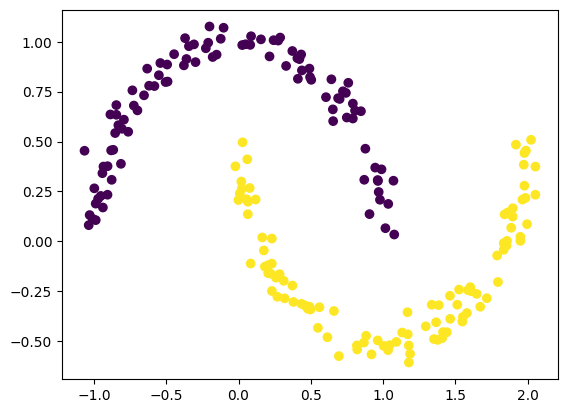

In [138]:
plt.scatter(moons[:200][0][:, 0], moons[:200][0][:, 1], c=moons[:200][1]) #, color=colors[moons[:200][1]])
plt.show()

In [139]:
X, y = moons[:]

In [140]:
X.shape

torch.Size([2000, 2])

In [141]:
# X = X[:, :, None].float()

## Training pipeline

In [142]:
def train_one_epoch():
    #running_loss = 0.
    #last_loss = 0.
    losses = []

    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        probas = model.predict_proba(inputs)
        loss = loss_fn(probas, labels.float())
        loss.backward()
        optimizer.step()
        #running_loss += loss.item()
        losses.append(loss.item())

    return losses

In [143]:
from IPython.display import clear_output

def train(epochs=100):
    losses = []
    for _ in range(epochs):
        losses += train_one_epoch()
        plt.plot(losses)
        plt.show()
        clear_output(wait=True)
    

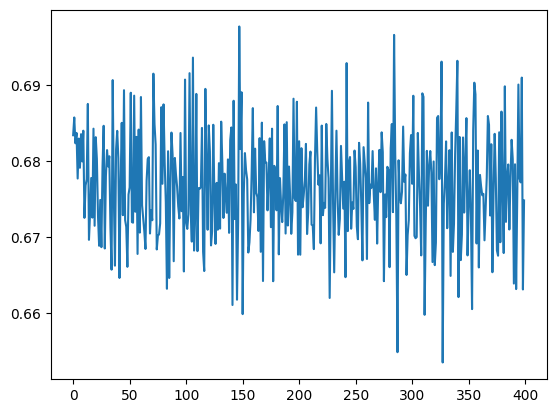

In [144]:
model = TTNet(1, 4, 2)
training_loader = torch.utils.data.DataLoader(moons, batch_size=512, shuffle=True)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train(epochs=100)

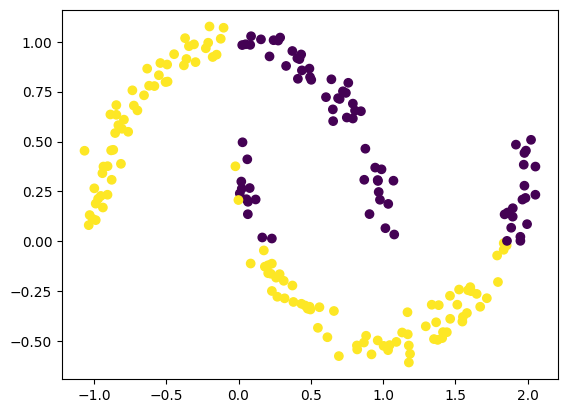

In [145]:
plt.scatter(moons[:200][0][:, 0], moons[:200][0][:, 1], c=model.predict(moons[:200][0]))
plt.show()

In [146]:
X.shape

torch.Size([2000, 2])

In [1]:
# import matplotlib.pyplot as plt
# from sklearn.inspection import DecisionBoundaryDisplay
# classifier = model
# disp = DecisionBoundaryDisplay.from_estimator(
#     classifier, X, response_method="predict",
#     xlabel="x", ylabel="y",
#     alpha=0.5,
# )
# disp.ax_.scatter(X[:, 0], X[:, 1], c=iris.target, edgecolor="k")
# plt.show()

# Rank of the matrix from the proof of Theorem

In [4]:
def f(tensor):
    x, y, z = tensor.shape
    n, r = y, z
    for ix in range(x):
        for iy in range(y):
            for iz in range(z):
                tensor[ix, iy, iz] = (iy == iz)
    return tensor

def g(tensor):
    x, y, z = tensor.shape
    _, n, r = x, y, z
    for ix in range(x):
        for iy in range(y):
            for iz in range(z):
                if ix < n:
                    tensor[ix, iy, iz] = (iy == (iz - n)) and (ix == iy)
                else:
                    tensor[ix, iy, iz] = (iy == iz)
    return tensor

def h(tensor):
    x, y, z = tensor.shape
    r, n = x, y
    for ix in range(x):
        for iy in range(y):
            for iz in range(z):
                tensor[ix, iy, iz] = (ix < n) and (ix == iy)
    return tensor

In [5]:
def gen_kernels(r = 5, n = 5):
    G_1 = np.zeros((1, n, r))
    G_i = np.zeros((r, n, r))
    G_d = np.zeros((r, n, 1))
    G_1 = f(G_1)
    G_i = g(G_i)
    G_d = h(G_d)
    return G_1, G_i, G_d

In [6]:
def compute(G_1, G_i, G_d, d = 4):
    assert d >= 2
    print("d =", d)
    _, n, r = G_1.shape
    curr_tensor = G_1
    for i in range(d-2):
        curr_tensor = np.tensordot(curr_tensor, G_i, axes=1)
    return np.tensordot(curr_tensor, G_d.reshape(r, n), axes=1)[0]

In [7]:
def matr(tensor):
    d = len(tensor.shape)
    n = tensor.shape[0]
    return np.transpose(tensor, np.arange(d).reshape(d // 2, 2).transpose().ravel()).reshape(n ** (d // 2), n ** (d // 2))
    

In [8]:
def numberToBase(n, b):
    if n == 0:
        return [0]
    digits = []
    while n:
        digits.append(int(n % b))
        n //= b
    return digits[::-1]


d = 4


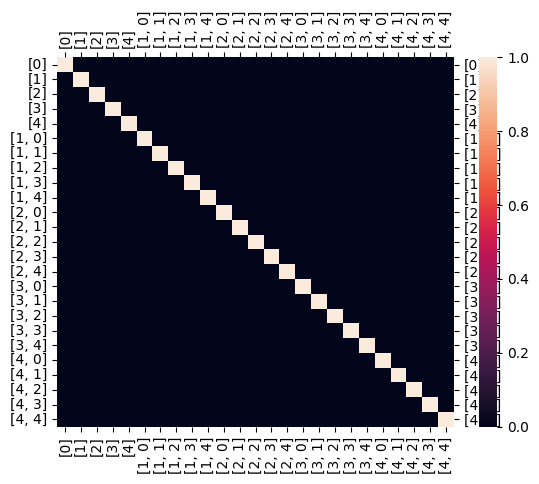

In [9]:
r = 10
n = 5
d = 4
ax = sns.heatmap(matr(compute(*gen_kernels(r=r, n=n), d=d)))
ax.tick_params(right=True, top=True, labelright=True, labeltop=True)
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')
ax.set_xticks(np.arange(0, n ** (d // 2)) + 0.5)
ax.set_xticklabels(map(lambda x: numberToBase(x, n), range(0, n ** (d // 2))))
ax.set_yticks(np.arange(0, n ** (d // 2)) + 0.5)
ax.set_yticklabels(map(lambda x: numberToBase(x, n), range(0, n ** (d // 2))))
plt.show()

In [11]:
from numpy.linalg import matrix_rank
M = matr(compute(*gen_kernels(r=r, n=n), d=d))
matrix_rank(M)

d = 4


25